<h1><center>Diplomado de Ciencias de Datos - Trabajo Final - Octubre 2021</center></h1> 
<h2><center>Caso Práctico: Sistema Provincial de Expedientes (SIE)</center></h2> 
<h3><center>3° Parte</center></h3>
<h4><center>Ing. Romina C. Scarazzini</center></h4>

___
# Contenido
- Limpieza de Datos con Power BI: Para ver el detalle de lo realizado en este paso, ver el documento: "Limpieza de Datos con Power BI.pdf"
- Exploración  y análisis de los datos
- Análisis de las características de Series Temporales (EDA)
- **Aplicación de modelos de Machine Learning, enfocados a Series Temporales**
  - **Paquetes de SkLearn**
    - **Modelo Autorregresivo: ForecasterAutoreg**
        - **Modelo Autorregresivo: ForecasterAutoreg con Intervalos de Predicción**
     - **Modelo Autorregresivo: ForecasterAutoregCustom**
    - **Modelo Autorregresivo: ForecasterAutoregMultiOutput** 
    - **Backtesting: Backtesting_forecaster**
       - **Backtesting con Intervalos de Predicción: Backtesting_forecaster_intervals**
    - **Comparación de Modelos Autorregresivos de Sklearn con modelos de Statsmodels**
- Predicciones 2021

___
# Importación de Paquetes

In [1]:
# Instalación de paquetes para tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Instalación de paquetes para gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#Declaración del estilo
#==========================
plt.style.use("bmh")

#Configuración del tamaño de las visualizaciones para que se muestren bien en Jupyter
#======================================
plt.rcParams["figure.figsize"] = 16, 5

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Importación de Paquetes de SkLearn
Es una librería que contiene las clases y funciones necesarias para adaptar cualquier modelo de regresón de scikit learn a problemas de forecasting. 

In [2]:
#Instalación desde pantala CMD: pip install skforecast
#=============================================================================
# Modelo Autorregresivo
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# Modelo Autorregresivo Customizado
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom

# Se usa en los modelo Autorregresivo y Autorregresivo Customizado
from sklearn.ensemble import RandomForestRegressor

# Modelo Autorregresivo Múltiple
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput

#Para ajuste de hiperparámetros
# Se usa en los modelo Autorregresivo, Autorregresivo Customizado y Autorregresivo Múltiple
from skforecast.model_selection import grid_search_forecaster

#Se usa para el modelo ForecasterAutoregMultiOutput
from sklearn.linear_model import Lasso

## Se usa para comparar este modelo de el modelo de Statmodel
## Se usa en backtesting y backtesting e intervalos de predicción
from sklearn.linear_model import LinearRegression

# Se usa para comparar este modelo de el modelo de SkLearn
from sklearn.linear_model import LinearRegression

# Backtesting
from skforecast.model_selection import backtesting_forecaster

# Intervalos de Prediccón y Backtesting
from skforecast.model_selection import backtesting_forecaster_intervals

## Paquetes para la Evaluación de Error de los Modelos

In [3]:
# Error Porcentual Absoluto Medio (MAPE)
# Este es uno de lo más usados para Series de Tiempo
#==========================================================
from sklearn.metrics import mean_absolute_percentage_error

# Error absoluto medio: Mean Squared Error (MAE)
#==========================================================
from sklearn.metrics import mean_absolute_error

# Error cuadrático medio: Mean Squared Error (MSE)
#===================================================
from sklearn.metrics import mean_squared_error

#Error logarítmico cuadrático medio
#===================================================
from sklearn.metrics import mean_squared_log_error

## Importación de Statsmodels
Statsmodels es un módulo de Python que proporciona clases y funciones para la estimación de muchos modelos estadísticos diferentes, así como para realizar pruebas estadísticas y exploración de datos estadísticos.

In [4]:
# Se usa en la comparación de el modelo "skforecast.ForecasterAutoreg" de Sklearn
#===============================================================
from statsmodels.tsa.ar_model import AutoReg

___
# Recupero los dataset trabajados en la 1° Parte del trabajo

In [5]:
# Defino como índice la 1° columna y diciendo que es una fecha
#======================================================================
df_total = pd.read_csv("df_total.csv", sep=';')
df_total.head()

,Fecha_Ini_Expte,Cant_Expte
0,2011-01-03,1144.0
1,2011-01-04,1217.0
2,2011-01-05,1326.0
3,2011-01-06,1377.0
4,2011-01-07,1388.0


___
## Preparación de los datos

In [6]:
df_total['Fecha_Ini_Expte'] = pd.to_datetime(df_total['Fecha_Ini_Expte'], format='%Y/%m/%d')
df_total = df_total.set_index('Fecha_Ini_Expte')

df_total = df_total.rename(columns={'Cant_Expte': 'y'})
df_total = df_total.asfreq('b')
df_total = df_total['y']
df_total = df_total.sort_index()

In [149]:
df_total

Fecha_Ini_Expte
2011-01-03    1144.0
2011-01-04    1217.0
2011-01-05    1326.0
2011-01-06    1377.0
2011-01-07    1388.0
               ...  
2020-12-24     760.0
2020-12-25    1142.0
2020-12-28    1142.0
2020-12-29    1125.0
2020-12-30    1447.0
Freq: B, Name: y, Length: 2608, dtype: float64

### Verifico que un índice temporal está completo

In [7]:
(df_total.index == pd.date_range(start=df_total.index.min(),
                              end=df_total.index.max(),
                              freq=df_total.index.freq)).all()

True

### Separación de los datos en Training y Test (80/20)

In [151]:
df_total.count()

2608

In [8]:
steps = 2086
datos_train = df_total[:steps]
datos_test  = df_total[steps:]

### Gráfico: Datos de Training, Test

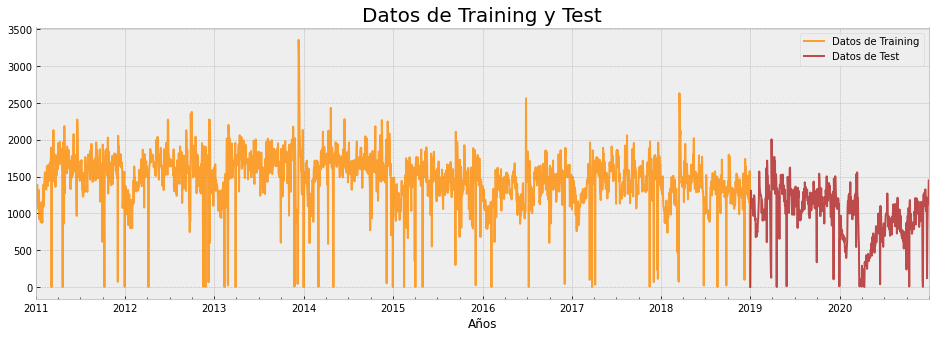

In [9]:
fig, ax=plt.subplots()
datos_train.plot(ax=ax, label='Datos de Training', color="darkorange", alpha=0.8)
datos_test.plot(ax=ax, label='Datos de Test', color="firebrick", alpha=0.8)
plt.title("Datos de Training y Test", fontsize=20)
plt.xlabel("Años")
ax.legend();

___
# Modelo Autorregresivo (FAR-SK) - ***ForecasterAutoreg***
- Un modelo autorregresivo (AR) es una representación de un proceso aleatorio, en el que la variable de interés depende linealmente de sus observaciones pasadas es decir de sus valores anteriores
- Se crea y entrena el modelo ForecasterAutoreg a partir de un regresor RandomForestRegressor y una ventana temporal de 5 lags. Esto último significa que, el modelo, utiliza como predictores los 5 días anteriores
### Crear y entrenar los datos con el modelo (FAR-SK)

In [34]:
Reg_FAR_SK = RandomForestRegressor(random_state=123)

FAR_SK = ForecasterAutoreg(Reg_FAR_SK, lags=5)

FAR_SK.fit(y=datos_train)

### Genero las predicciones

In [35]:
Steps_FAR_SK = 522
Pred_FAR_SK = FAR_SK.predict(steps=Steps_FAR_SK)

# Se añade el índice temporal a las predicciones
Pred_FAR_SK = pd.Series(data=Pred_FAR_SK, index=datos_test.index)
Pred_FAR_SK.head()

Fecha_Ini_Expte
2019-01-01    1213.94
2019-01-02    1169.17
2019-01-03    1432.34
2019-01-04    1403.43
2019-01-07    1277.98
Freq: B, dtype: float64

### Gráfico: Datos de Training, Test y Predicciones usando el modelo FAR-SK

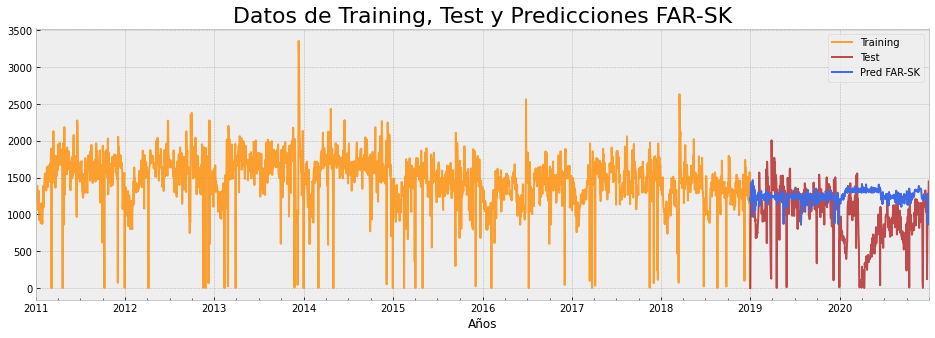

In [40]:
fig, ax = plt.subplots()
datos_train.plot(ax=ax, label='Training', color="darkorange", alpha=0.8)
datos_test.plot(ax=ax, label='Test', color="firebrick", alpha=0.8)
Pred_FAR_SK.plot(ax=ax, label='Pred FAR-SK', color="royalblue", alpha=1)
plt.title("Datos de Training, Test y Predicciones FAR-SK", fontsize=22)
plt.xlabel("Años")
ax.legend();

___
## Evaluación del Error del Modelo SK-AR

### MAE (Error Absoluto Medio)

In [14]:
MAE = mean_absolute_error(datos_test,Pred_FAR_SK)
print(f'MAE del modelo SK-AR: {MAE:11.10}')

MAE del modelo SK-AR: 345.7714943


### MAPE (Error Porcentual Absoluto Medio)

In [15]:
MAPE = mean_absolute_percentage_error(datos_test,Pred_FAR_SK)
print(f'MAPE del modelo SK-AR: {MAPE:11.10}')

MAPE del modelo SK-AR: 11.41324581


### MSE (Error Cuadrático Medio)

In [16]:
MSE = mean_squared_error(datos_test,Pred_FAR_SK)
print(f'MSE del modelo SK-AR: {MSE:11.10}')

MSE del modelo SK-AR: 220630.6782


___
## Optimización del Modelo (FAR-SK) - Ajuste de hiperparámetros (tuning) 
- El "ForecasterAutoreg" entrenado ha utilizado una ventana temporal de 5 lags y un modelo Random Forest con los hiperparámetros por defecto 
- Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados
- Para identificar la mejor combinación de lags e hiperparámetros, la librería skforecast dispone de la estrategia de validación cruzada temporal y de backtesting
- Independientemente de la estrategia utilizada, es importante no incluir los datos de test en el proceso de búsqueda para no caer en problemas de overfitting
- A continuación, se utiliza el primer 50% de observaciones de entrenamiento para el entrenamiento inicial y el segundo 50% para la comparación de los modelos

### Se prepara y ejecuta "grid search" de para optimizar los hiperparámetros

In [17]:
Reg_FAR_SK = RandomForestRegressor(random_state=123)

FAR_SK = ForecasterAutoreg(regressor = Reg_FAR_SK, lags=5)
# El valor de lags, será remplazado en el grid search

# Hiperparámetros del regresor
param_grid_FAR_SK = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags utilizados como predictores
lags_grid_FAR_SK = [5, 20, 22, 260]

resul_grid_FAR_SK = grid_search_forecaster(
                      forecaster  = FAR_SK,
                      y           = datos_train,
                      param_grid  = param_grid_FAR_SK,
                      lags_grid   = lags_grid_FAR_SK,
                      steps       = 522,
                      method      = 'cv',
                      metric      = 'mean_absolute_percentage_error',
                      initial_train_size    = int(len(datos_train)*0.5),
                      allow_incomplete_fold = False,
                      return_best = True,
                      verbose     = False
                   )

2021-09-24 11:24:12,131 root       INFO  Number of models to fit: 24
loop lags_grid: 100%|████████████████████████████████████████████████████████████████████| 4/4 [04:18<00:00, 64.53s/it]
2021-09-24 11:28:30,261 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [1 2 3 4 5] 
params: {'max_depth': 10, 'n_estimators': 100}



### Resultados de la Grid Search

In [18]:
resul_grid_FAR_SK

,lags,params,metric
4,"[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 100}",11.422422
0,"[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 100}",11.946836
5,"[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 500}",14.734268
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",15.718705
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",15.817363
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",15.831095
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",15.851582
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",15.866297
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",15.881335
2,"[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 100}",15.948775


#### Conclusiones
Los mejores resultados se obtienen si se utiliza una **ventana temporal de 5 lags** y una configuración de **random forest {'max_depth': 10, 'n_estimators': 100}**

___
## Modelo FAR-SK Optimizado
- Finalmente, se entrena de nuevo un **ForecasterAutoreg** con la configuración óptima encontrada en el proceso de grid search

### Creo y entreno el modelo FAR-SK con los hiperparámetros optimizados

In [11]:
Reg_FAR_SK_O = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=123)

FAR_SK_O = ForecasterAutoreg(regressor=Reg_FAR_SK_O, lags=5)

FAR_SK_O.fit(y=datos_test)

### Predicciones con el Modelo FAR-SK Otimizado

In [12]:
Steps_FAR_SK_O = 522
Pred_FAR_SK_O = FAR_SK_O.predict(steps=Steps_FAR_SK_O)

# Se añade el índice a las predicciones
Pred_FAR_SK_O = pd.Series(data=Pred_FAR_SK_O, index=datos_test.index)

### Gráfico: Datos de Training, Test y Predicciones del modelo FAR-SK con Hiperparámetros Optimizados

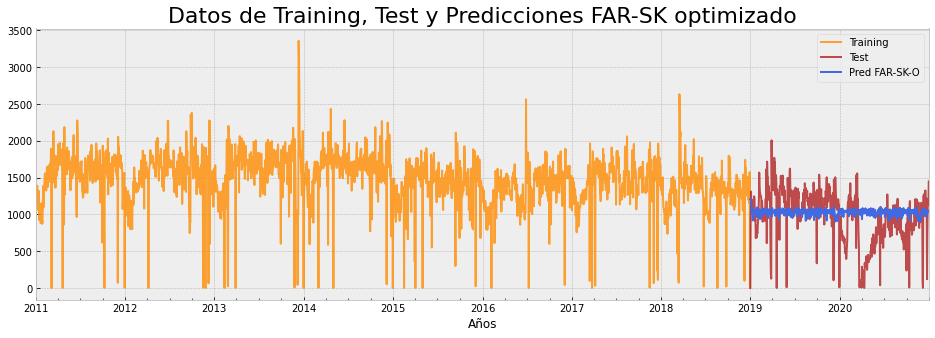

In [41]:
fig, ax = plt.subplots()
datos_train.plot(ax=ax, label='Training', color="darkorange", alpha=0.8)
datos_test.plot(ax=ax, label='Test', color="firebrick", alpha=0.8)
Pred_FAR_SK_O.plot(ax=ax, label='Pred FAR-SK-O', color="royalblue", alpha=1)
plt.title("Datos de Training, Test y Predicciones FAR-SK optimizado", fontsize=22)
plt.xlabel("Años")
ax.legend();

___
## Evaluación del Error del Modelo FAR-SK-O

### MAE (Error Absoluto Medio)

In [22]:
MAE = mean_absolute_error(datos_test,Pred_FAR_SK_O)
print(f'MAE del modelo SK-AR: {MAE:11.10}')

MAE del modelo SK-AR: 280.6491988


### MAPE (Error Porcentual Absoluto Medio)

In [23]:
MAPE = mean_absolute_percentage_error(datos_test,Pred_FAR_SK_O)
print(f'MAPE del modelo SK-AR: {MAPE:11.10}')

MAPE del modelo SK-AR: 9.790082285


### MSE (Error Cuadrático Medio)

In [24]:
MSE = mean_squared_error(datos_test,Pred_FAR_SK_O)
print(f'MSE del modelo SK-AR: {MSE:11.10}')

MSE del modelo SK-AR: 134302.8809


### Conclusiones
- Con la optimizacipon de los hiperparámetros del modelo AR-SK-O, se consigue reducir el error y por ende mejorar el modelo

___
# Modelo Autorregresivo con predictores Custom (FARC-SK) - ***ForecasterAutoregCustom***
- En determinados escenarios, puede ser interesante incorporar otras características de la serie temporal además de los lags, por ejemplo, la media movil de los últimos n valores puede servir para capturar la tendencia de la serie
- La clase **ForecasterAutoregCustom** se comporta de forma muy similar a la clase ForecasterAutoreg con la diferencia de que, es el usuario quien define la función empleada para crear los predictores
- Voy a usar como predictores los 10 primeros lags y la media móvil de los últimos 2 años (260 días labolares)
- Se crea y entrena un ForecasterAutoregCustom a partir de un regresor RandomForestRegressor

### Función para calcular los predictores a partir de la serie temporal

In [15]:
def create_predictors(y):
    '''
    Crear los primeros 10 lags.
    Calcular la media móvil de los últimos 260 valores.
    '''
    
    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 10):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)
        
    X_train['moving_avg'] = X_train['y'].rolling(260).mean()
    
    X_train = X_train.drop(columns='y').tail(1).to_numpy()  
    
    return X_train  

### Crear y entrenar el Modelo FARC-SK
Al crear el forecaster, el argumento window_size debe ser un valor, como mínimo, tan grande como la ventana que utiliza la función que crea los predictores. En este caso 260

In [20]:
Reg_FARC_SK = RandomForestRegressor(random_state=123)

FARC_SK = ForecasterAutoregCustom(regressor = Reg_FARC_SK, fun_predictors = create_predictors, window_size = 260)

FARC_SK.fit(y=datos_train)

### Predicciones usando FARC-SK

In [21]:
Steps_FARC_SK = 522
Pred_FARC_SK = FARC_SK.predict(steps=Steps_FARC_SK)

# Se añade el índice temporal a las predicciones
Pred_FARC_SK = pd.Series(data=Pred_FARC_SK, index=datos_test.index)

### Gráfico: Datos de Training, Test y Predicciones del modelo FARC-SK

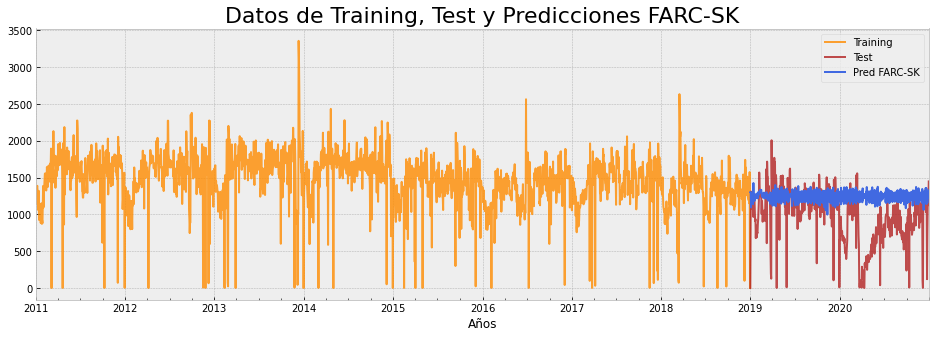

In [43]:
fig, ax = plt.subplots()
datos_train.plot(ax=ax, label='Training', color="darkorange", alpha=0.8)
datos_test.plot(ax=ax, label='Test', color="firebrick", alpha=0.8)
Pred_FARC_SK.plot(ax=ax, label='Pred FARC-SK', color="royalblue", alpha=1)
plt.title("Datos de Training, Test y Predicciones FARC-SK", fontsize=22)
plt.xlabel("Años")
ax.legend();

___
## Evaluación del Error del Modelo FARC-SK

### MAE (Error Absoluto Medio)

In [23]:
MAE = mean_absolute_error(datos_test,Pred_FARC_SK)
print(f'MAE del modelo SK-AR: {MAE:11.10}')

MAE del modelo SK-AR: 333.2343103


### MAPE (Error Porcentual Absoluto Medio)

In [24]:
MAPE = mean_absolute_percentage_error(datos_test,Pred_FARC_SK)
print(f'MAPE del modelo SK-AR: {MAPE:11.10}')

MAPE del modelo SK-AR: 11.27621406


### MSE (Error Cuadrático Medio)

In [25]:
MSE = mean_squared_error(datos_test,Pred_FARC_SK)
print(f'MSE del modelo SK-AR: {MSE:11.10}')

MSE del modelo SK-AR: 201204.7294


### Conclusiones
- El error del modelo FARC-SK es menor que el error del modelo FARC-SK, pero es mayor que el error del modelo FARC-SK Optimizado

____
## Optimización del Modelo FARC-SK  - Ajuste de hiperparámetros (tuning)
- Al utilizar la función grid_search_forecaster() con un ForecasterAutoregCustom, no se indica el argumento lags_grid.

### Grid search de hiperparámetros

In [33]:
Reg_FARC_SK = RandomForestRegressor(random_state=123)

FARC_SK = ForecasterAutoregCustom(regressor = Reg_FARC_SK, fun_predictors = create_predictors, window_size = 260)

# Hiperparámetros del regresor
param_grid_FARC_SK = {'n_estimators': [100, 500],
                      'max_depth': [3, 5, 10]}

resul_grid_FARC_SK = grid_search_forecaster(
                     forecaster  = FARC_SK,
                     y           = datos_train,
                     param_grid  = param_grid_FARC_SK,
                     steps       = 522,
                     method      = 'cv',
                     metric      = 'mean_absolute_percentage_error',
                     initial_train_size    = int(len(datos_train)*0.5),
                     allow_incomplete_fold = True,
                     return_best = True,
                     verbose     = False)

2021-09-24 11:39:15,423 root       INFO  Number of models to fit: 6
loop lags_grid: 100%|███████████████████████████████████████████████████████████████████| 1/1 [02:47<00:00, 167.39s/it]
2021-09-24 11:42:02,815 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 3, 'n_estimators': 100}



### Resultados Grid Search

In [34]:
resul_grid_FARC_SK

,lags,params,metric
0,custom predictors,"{'max_depth': 3, 'n_estimators': 100}",10.389415
1,custom predictors,"{'max_depth': 3, 'n_estimators': 500}",10.468850
2,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",10.823028
5,custom predictors,"{'max_depth': 10, 'n_estimators': 500}",10.948677
4,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",11.213254
3,custom predictors,"{'max_depth': 5, 'n_estimators': 500}",12.089096


### Conclusiones
Los mejores resultados se obtienen utilizando **max_depth = 3** y **n_estimators =100**

___
## Modelo FARC-SK optimizado

### Crear y entrenar FARC-SKFARC-SK Optimizado

In [26]:
Reg_FARC_SK_O = RandomForestRegressor(max_depth=3, n_estimators=100, random_state=123)

FARC_SK_O = ForecasterAutoregCustom(regressor = Reg_FARC_SK_O, fun_predictors = create_predictors, window_size = 260)

FARC_SK_O.fit(y=datos_test)

### Predicciones usando ForecasterAutoregCustom Optimizado

In [27]:
Steps_FARC_SK_O = 522
Pred_FARC_SK_O = FARC_SK_O.predict(steps=Steps_FARC_SK)

# Se añade el índice temporal a las predicciones
Pred_FARC_SK_O = pd.Series(data=Pred_FARC_SK_O, index=datos_test.index)

### Gráfico: Datos de Training, Test y Predicciones del modelo ForecasterAutoregCustom optimizado

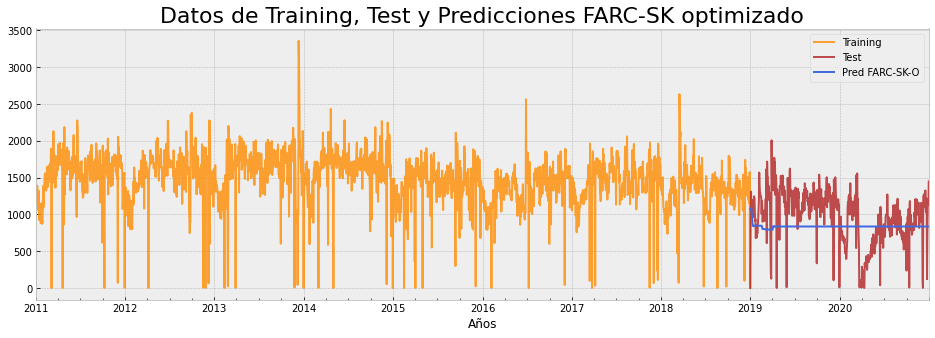

In [44]:
fig, ax = plt.subplots()
datos_train.plot(ax=ax, label='Training', color="darkorange", alpha=0.8)
datos_test.plot(ax=ax, label='Test', color="firebrick", alpha=0.8)
Pred_FARC_SK_O.plot(ax=ax, label='Pred FARC-SK-O', color="royalblue", alpha=1)
plt.title("Datos de Training, Test y Predicciones FARC-SK optimizado", fontsize=22)
plt.xlabel("Años")
ax.legend();

___
## Evaluación del Error del Modelo FARC-SK-O

### MAE (Error Absoluto Medio)

In [39]:
MAE = mean_absolute_error(datos_test,Pred_FARC_SK_O)
print(f'MAE del modelo SK-AR: {MAE:11.10}')

MAE del modelo SK-AR: 323.0907885


### MAPE (Error Porcentual Absoluto Medio)

In [40]:
MAPE = mean_absolute_percentage_error(datos_test,Pred_FARC_SK_O)
print(f'MAPE del modelo SK-AR: {MAPE:11.10}')

MAPE del modelo SK-AR: 8.025094577


### MSE (Error Cuadrático Medio)

In [41]:
MSE = mean_squared_error(datos_test,Pred_FARC_SK_O)
print(f'MSE del modelo SK-AR: {MSE:11.10}')

MSE del modelo SK-AR: 149716.4741


### Conclusiones
- Con la optimizacipon de los hiperparámetros del modelo FARC-SK, se consigue reducir el error y por ende mejorar el modelo
- Pero en la gráfica vemos que este modelo no predice de muy bien a nuestra serie de tiempo

___
## Forecasting Autorregresivo Directo de Múltiples Pasos (FARMS-SK)
- Los modelos ForecasterAutoreg y ForecasterAutoregCustom siguen una estrategia de predicción recursiva en la que, cada nueva predicción, se basa en la predicción anterior
- El método **direct multi-step forecasting** consiste en entrenar un modelo distinto para cada step. Por ejemplo, si se quieren predecir los siguientes 5 valores de una serie temporal, se entrenan 5 modelos distintos, uno para cada step. Como resultado, las predicciones son independientes unas de otras
- La principal complejidad de esta aproximación consiste en generar correctamente las matrices de entrenamiento para cada modelos. Todo este proceso está automatizado en la clase ForecasterAutoregMultiOutput de la librería skforecast
- También es importante tener en cuenta que esta estrategia tiene un coste computacional más elevado ya que requiere entrenar múltiples modelos
>
- A diferencia de cuando se utiliza ForecasterAutoreg o ForecasterAutoregCustom, en los modelos de tipo ForecasterAutoregMultiOutput hay que indicar, en el momento de su creación, el número de steps que se quieren predecir. Esto significa que el número de predicciones obtenidas al ejecutar el método predict() es siempre el mismo
### Grid search de hiperparámetros

In [48]:
Reg_FARMS_SK = Lasso(random_state=123)

FARMS_SK = ForecasterAutoregMultiOutput(regressor = Reg_FARMS_SK, steps = 522, lags = 5)
# El valor de lags será remplazado en el grid search

param_grid_FARMS_SK = {'alpha': np.logspace(start=-5, stop=5, num=10)}

lags_grid_FARMS_SK = [5,22,260]

resul_grid_FARMS_SK = grid_search_forecaster(
                      forecaster  = FARMS_SK,
                      y           = datos_train,
                      param_grid  = param_grid_FARMS_SK,
                      lags_grid   = lags_grid_FARMS_SK,
                      steps       = 522,
                      method      = 'cv',
                      metric      = 'mean_absolute_percentage_error',
                      initial_train_size    = int(len(datos_train)*0.5),
                      allow_incomplete_fold = False,
                      return_best = True,
                      verbose     = False)

2021-09-26 11:17:12,337 root       INFO  Number of models to fit: 30
loop lags_grid: 100%|████████████████████████████████████████████████████████████████████| 3/3 [02:41<00:00, 53.92s/it]
2021-09-26 11:19:54,096 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 16

### Resultados Grid Search

In [49]:
resul_grid_FARMS_SK.head()

,lags,params,metric
27,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 599.4842503189421},10.281695
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 46.41588833612782},12.545152
28,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 7742.636826811277},13.326861
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1e-05},14.497293
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.0001291549665014884},14.497293


### Conclusión
- Los mejores resultados se obtienen utilizando una ventana temporal de **260 lags** y una configuración de **Lasso con un alpha = 599,4842503189421**

### Crear y entrenar FARMS-SK Optimizado

In [46]:
alpha_FARMS_SK_O = 599.4842503189421

Reg_FARMS_SK_O = Lasso(alpha = alpha_FARMS_SK_O)

FARMS_SK_O = ForecasterAutoregMultiOutput(regressor = Reg_FARMS_SK_O, steps = 522, lags = 260)

FARMS_SK_O.fit(y=datos_train)

In [81]:
FARMS_SK_O

============================ForecasterAutoregMultiOutput============================
Regressor: Lasso(alpha=599.4842503189421)
Steps: 522
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 

### Predicciones usando FARMS-SK Optimizado

In [47]:
Pred_FARMS_SK_O = FARMS_SK_O.predict()

# Se añade el índice a las predicciones
Pred_FARMS_SK_O = pd.Series(Pred_FARMS_SK_O, index=datos_test.index)


### Gráfico: Datos de Training, Test y Predicciones del Modelo FARMS-SK Optimizado

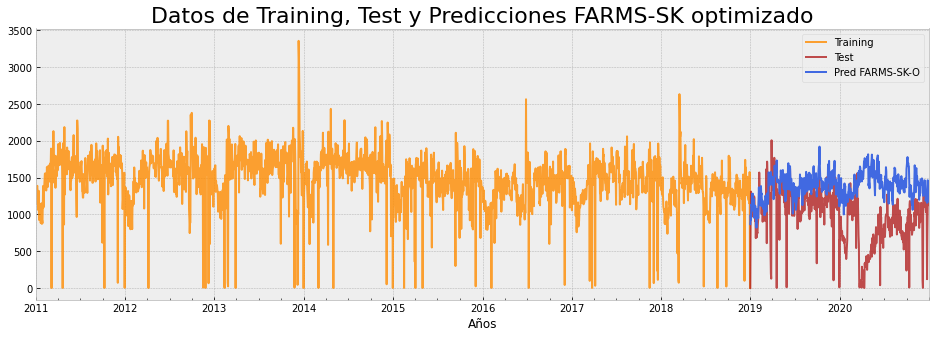

In [48]:
fig, ax = plt.subplots()
datos_train.plot(ax=ax, label='Training', color="darkorange", alpha=0.8)
datos_test.plot(ax=ax, label='Test', color="firebrick", alpha=0.8)
Pred_FARMS_SK_O.plot(ax=ax, label='Pred FARMS-SK-O', color="royalblue", alpha=1)
plt.title("Datos de Training, Test y Predicciones FARMS-SK optimizado", fontsize=22)
plt.xlabel("Años")
ax.legend();

___
## Evaluación del Error del Modelo FARMS-SK-O

### MAE (Error Absoluto Medio)

In [84]:
MAE = mean_absolute_error(datos_test,Pred_FARMS_SK_O)
print(f'MAE del modelo SK-AR: {MAE:11.10}')

MAE del modelo SK-AR: 442.3004121


### MAPE (Error Porcentual Absoluto Medio)

In [85]:
MAPE = mean_absolute_percentage_error(datos_test,Pred_FARMS_SK_O)
print(f'MAPE del modelo SK-AR: {MAPE:11.10}')

MAPE del modelo SK-AR:  12.9475029


### MSE (Error Cuadrático Medio)

In [86]:
MSE = mean_squared_error(datos_test,Pred_FARMS_SK_O)
print(f'MSE del modelo SK-AR: {MSE:11.10}')

MSE del modelo SK-AR: 343931.3842


### Conclusiones
- Vemos que el MAPE es más alto que en el resto de modelos de SE probados
- En la gráfica vemos que las predicciones de este modelo son adecuadas para nuestra serie de datos

___
## Modelo Backtesting (BT-SK)
- El proceso de backtesting consiste en simular el comportamiento que habría tenido el modelo si se hubiese ido ejecutando de forma recurrente, por ejemplo, prediciendo a intervalos de 2 años (522 días laborales)
- Este tipo de evaluación puede aplicarse fácilmente con la función backtesting_forecaster()
- Esta función devuelve, además de las predicciones, una métrica de error

In [136]:
steps_BT = 522
reg_BT = LinearRegression()
BT = ForecasterAutoreg(regressor=reg_BT, lags=260)

metric_BT, Pred_BT = backtesting_forecaster(
                     forecaster = BT,
                     y          = df_total,
                     initial_train_size = len(datos_train),
                    steps      = steps,
                    metric     = 'mean_absolute_percentage_error',
                    verbose    = True
                               )

print(f" Error de backtest: {metric_BT}")

Number of observations used for training: 2086
Number of observations used for testing: 522
    Number of folds: 1
    Number of steps per fold: 2086
    Last fold only includes 522 observations
 Error de backtest: [11.19978387]


In [137]:
# Add datetime index to predictions
Pred_BT = pd.Series(data=Pred_BT, index=datos_test.index)

### Gráfico: Datos de Test y Predicciones usando el modelo Backtesting

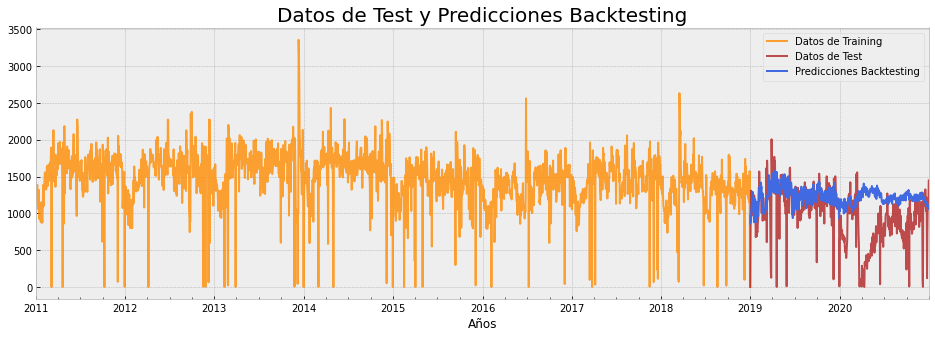

In [138]:
fig, ax = plt.subplots()
datos_train.plot(ax=ax, label='Datos de Training', color="darkorange", alpha=0.8)
datos_test.plot(ax=ax, label='Datos de Test', color="firebrick", alpha=0.8)
Pred_BT.plot(ax=ax, label='Predicciones Backtesting', color="royalblue", alpha=1)
plt.title("Datos de Test y Predicciones Backtesting", fontsize=20)
plt.xlabel("Años")
ax.legend();

### Intervalos de predicción para el modelo Backtesting (BT)

In [139]:
steps_BTeIP = 522
BTeIP = ForecasterAutoreg(regressor=LinearRegression(), lags=260)

metric_BTeIP, Pred_BTeIP = backtesting_forecaster_intervals(
                     forecaster = BTeIP,
                     y          = df_total,
                     initial_train_size = len(datos_train),
                     steps      = steps_BTeIP,
                     metric     = 'mean_absolute_percentage_error',
                     interval            = [1, 99],
                     n_boot              = 100,
                     in_sample_residuals = True,
                     verbose             = True
                     )

print(metric_BTeIP)

Number of observations used for training: 2086
Number of observations used for testing: 522
    Number of folds: 1
    Number of steps per fold: 522
[11.19978387]


### Se añade índice datetime

In [140]:
Pred_BTeIP = pd.DataFrame(data=Pred_BTeIP, index=datos_test.index)

___
## Evaluación del Error del Modelo BT-SK

### MAE (Error Absoluto Medio)

In [141]:
MAE = mean_absolute_error(datos_test,Pred_BT)
print(f'MAE del modelo SK-AR: {MAE:11.10}')

MAE del modelo SK-AR: 313.0626793


### MAPE (Error Porcentual Absoluto Medio)

In [142]:
MAPE = mean_absolute_percentage_error(datos_test,Pred_BT)
print(f'MAPE del modelo SK-AR: {MAPE:11.10}')

MAPE del modelo SK-AR: 11.19978387


### MSE (Error Cuadrático Medio)

In [143]:
MSE = mean_squared_error(datos_test,Pred_BT)
print(f'MSE del modelo SK-AR: {MSE:11.10}')

MSE del modelo SK-AR: 192407.0778


### Gráfico: Datos de Test y Predicciones usando Modelo Backtesting con Intervalos de predicción 

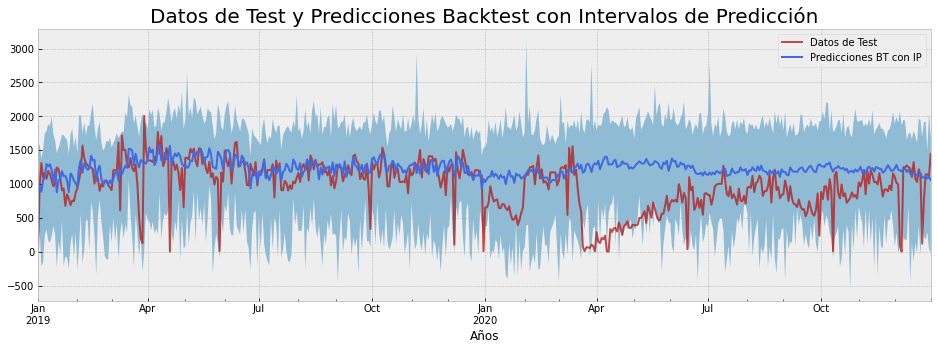

In [144]:
fig, ax = plt.subplots()
#datos_train.plot(ax=ax, label='Datos de Training', color="darkorange", alpha=0.8)
datos_test.plot(ax=ax, label='Datos de Test', color="firebrick", alpha=0.8)
Pred_BTeIP.iloc[:, 0].plot(ax=ax, label='Predicciones BT con IP', color="royalblue", alpha=1)
plt.title("Datos de Test y Predicciones Backtest con Intervalos de Predicción", fontsize=20)
ax.fill_between(Pred_BTeIP.index,
                Pred_BTeIP.iloc[:, 1],
                Pred_BTeIP.iloc[:, 2],
                alpha=0.5)
plt.xlabel("Años")
ax.legend();

## Conclusiones Finales para los Modelos SkLearn
- El MAPE para cada modelo analizado de SkLearn es:
  - FAR-SK: 11,41%
  - FAR-SK-O: 9,79%
  - FARC-SK: 11,27
  - **FARC-SK-O: 8,02%**
  - FARMS-SK-O: 2,48% (solo para la predicción de 1 año laboral)
  - BT-SK: 11,20%
  
- Podemos observar que de los modelos de SkLearn analizados, el modelo con **mejor MAPE** es el modelo Autorregresivo Customizado con hiperparámetros Optimizados - **FARC-SK-O**

___
# Comparación con Statsmodels
La librería **statsmodels** dispone de algunos de los principales **modelos de forecasting (AutoReg, AR, ARMA, ARIMA)**

### Modelo autorregresivo lineal statsmodels

In [145]:
lags_FAR_ST = 260
FAR_ST = AutoReg(datos_train, lags=lags_FAR_ST)
Res_FAR_ST = FAR_ST.fit()
Pred_FAR_ST = Res_FAR_ST.predict(start=datos_test.index[0], end=datos_test.index[-1])

### Modelo autorregresivo lineal Forecaster

In [146]:
Steps_FLR_SK = 522
lags_FLR_SK = 260
Reg_FLR_SK = LinearRegression()
FLR_SK = ForecasterAutoreg(regressor=Reg_FLR_SK, lags=lags_FLR_SK)
FLR_SK.fit(y=datos_train)
Pred_FLR_SK = FLR_SK.predict(steps=Steps_FLR_SK)

### Verificación de que las predicciones de ambos modelos son iguales

In [147]:
print(np.allclose(Pred_FAR_ST.values, Pred_FLR_SK))

True


### Verificación de que los coeficientes de ambos modelos son iguales

In [148]:
print(np.allclose(Res_FAR_ST.params.values[1:], FLR_SK.get_coef()))

True


### Conclusiones
- Se verifica que se obtienen los mismos resultados con el método **AutoReg de StatModel** y con el método **ForecasterAutoreg de SkLearn** uando el modelo de **LinearRegression()**
- Igualmente vamos a analizar en detalle algunos modelos del paquete de **StatModel** para verificar como funcionan sobre nuestra serie de tiempo